<a href="https://colab.research.google.com/github/SofiaAkhtar/MRI-Brain-Tumor-Detection-using-Vision-Transformers-ViT-/blob/main/Brain_Tumour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# Update this path according to where you uploaded it
base_path = "/content/drive/MyDrive/brain_tumor_data"

train_dir = base_path + "/Training"
test_dir = base_path + "/Testing"

In [ ]:
import os
print("Training classes:", os.listdir(train_dir))
print("Testing classes:", os.listdir(test_dir))


Training classes: ['glioma', 'meningioma', 'pituitary', 'notumor']
Testing classes: ['glioma', 'notumor', 'meningioma', 'pituitary']


**Types**
* Glioma → A malignant brain tumor that originates from glial (supporting) cells of the brain.

* Meningioma → A mostly benign tumor that arises from the protective membranes (meninges) around the brain and spinal cord.

* Pituitary Tumor → A generally benign tumor located in the pituitary gland, affecting hormone regulation.

* No Tumor → Normal brain MRI with no visible tumor.

In [ ]:
import os

def count_images_in_dir(directory):
    total = 0
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_name] = count
            total += count
    return total, class_counts

train_total, train_counts = count_images_in_dir(train_dir)
test_total, test_counts = count_images_in_dir(test_dir)

print("📌 Training Set:")
print("Total:", train_total)
print(train_counts)

print("\n📌 Testing Set:")
print("Total:", test_total)
print(test_counts)


📌 Training Set:
Total: 5712
{'glioma': 1321, 'meningioma': 1339, 'pituitary': 1457, 'notumor': 1595}

📌 Testing Set:
Total: 1311
{'glioma': 300, 'notumor': 405, 'meningioma': 306, 'pituitary': 300}


In [ ]:
# Imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import TFViTForImageClassification
import matplotlib.pyplot as plt
import numpy as np


In [ ]:

# Parameters
img_size = 224   # resize all images
batch_size = 32

# Train data generator (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% train, 20% val from Training/
)

# Validation generator
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Test generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',   # 4 classes
    subset='training',
    shuffle=True
)

# Validation set
val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


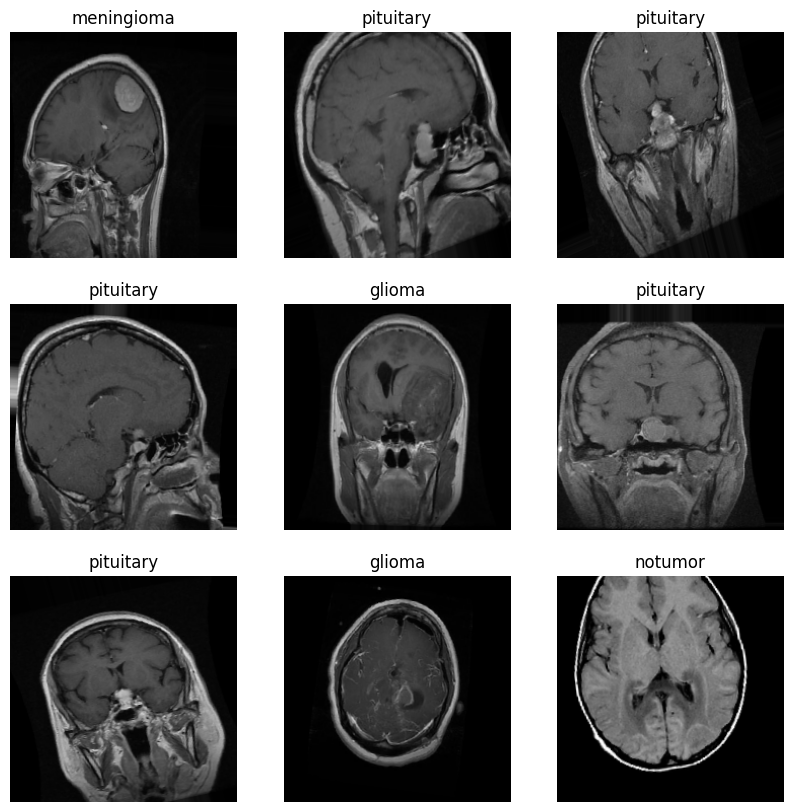

In [ ]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_batch[i])
    label = list(train_generator.class_indices.keys())[y_batch[i].argmax()]
    plt.title(label)
    plt.axis("off")
plt.show()


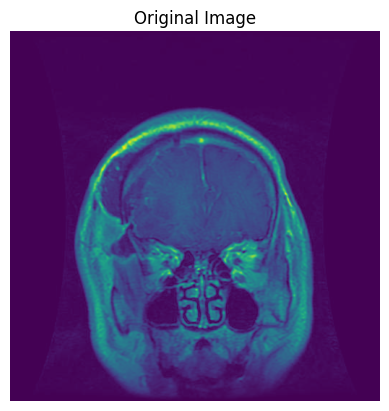

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Pick one sample image from training directory
sample_img_path = os.path.join(train_dir, "glioma", os.listdir(os.path.join(train_dir, "glioma"))[0])

# Show original image
plt.imshow(mpimg.imread(sample_img_path))
plt.title("Original Image")
plt.axis("off")
plt.show()


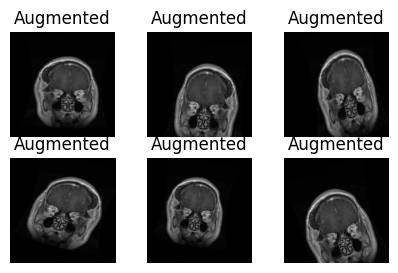

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Load image and reshape for generator
img = load_img(sample_img_path, target_size=(img_size, img_size))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)  # shape (1, h, w, c)

# Use the same augmentation as train_datagen
aug_iter = train_datagen.flow(x, batch_size=1)

# Generate and plot augmented images
plt.figure(figsize=(5,3))
for i in range(6):
    aug_img = next(aug_iter)[0]
    plt.subplot(2,3,i+1)
    plt.imshow(aug_img)
    plt.title("Augmented")
    plt.axis("off")
plt.show()


**CLAHE**

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
def apply_clahe(img):
    # img comes as RGB (224x224x3) from ImageDataGenerator
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # Convert back to RGB (ViT expects 3 channels)
    enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)

    return enhanced_rgb


In [ ]:
def clahe_preprocessing(img):
    return np.array([apply_clahe(x) for x in img])


In [ ]:
# Train generator with CLAHE
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=apply_clahe   # 👈 CLAHE applied here
)

# Validation generator (CLAHE + rescaling)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=apply_clahe
)

# Test generator (CLAHE only, no augmentation)
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=apply_clahe
)


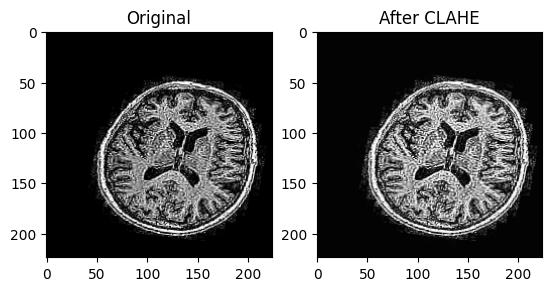

In [ ]:
import matplotlib.pyplot as plt

sample_img, _ = next(train_generator)
original = sample_img[0]

clahe_applied = apply_clahe((original*255).astype(np.uint8))

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(original)

plt.subplot(1,2,2)
plt.title("After CLAHE")
plt.imshow(clahe_applied)
plt.show()
